First of all, lets import the libraries we will need for the analysis.

In [139]:
%matplotlib inline
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as ani
import matplotlib.colors as cl
import matplotlib.cm as cm
import io
import random
import base64
import nltk
from mpl_toolkits.basemap import Basemap
from collections import Counter 
from os import path
from PIL import Image
from collections import defaultdict
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from IPython.display import display, HTML


Transform data into a data frame

In [3]:
data = pd.read_csv("~/Faculdade/ICD/Projeto/Data/gtd.csv", encoding='ISO-8859-1')

data.head(5)

/home/matheusfebarbosa/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (4,6,31,33,61,62,63,76,79,90,92,94,96,114,115,121) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
0,197000000001,1970,7,2,NaN,0,NaN,58,Dominican Republic,2,...,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN
1,197000000002,1970,0,0,NaN,0,NaN,130,Mexico,1,...,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
2,197001000001,1970,1,0,NaN,0,NaN,160,Philippines,5,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
3,197001000002,1970,1,0,NaN,0,NaN,78,Greece,8,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
4,197001000003,1970,1,0,NaN,0,NaN,101,Japan,4,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN


Lets separate the columns we will need, and give them a better name.

In [4]:
mapper = {'iyear':'Year' , 'country_txt': 'Country', 
          'latitude':'Latitude', 'longitude':'Longitude',
          'summary':'Summary', 'success':'Success',
          'target1':'Target', 'targtype1_txt':'TargetType',
          'attacktype1_txt':'AttackType', 'gname':'Group',
          'weaptype1_txt':'WeaponType','nkill':'Kills',
          'nwound':'Wounds' , 'motive':'Motive'}

data.rename(columns=mapper,inplace=True);

data = data[['Year' , 'Country', 'Latitude', 'Longitude',
          'Summary', 'Success','Target', 'TargetType',
          'AttackType', 'Group','WeaponType','Kills',
          'Wounds','Motive']]

data.fillna(0,inplace=True)
data.head(5)

,Year,Country,Latitude,Longitude,Summary,Success,Target,TargetType,AttackType,Group,WeaponType,Kills,Wounds,Motive
0,1970,Dominican Republic,18.456792,-69.951164,0,1,Julio Guzman,Private Citizens & Property,Assassination,MANO-D,Unknown,1.0,0.0,0
1,1970,Mexico,19.371887,-99.086624,0,1,"Nadine Chaval, daughter",Government (Diplomatic),Hostage Taking (Kidnapping),23rd of September Communist League,Unknown,0.0,0.0,0
2,1970,Philippines,15.478598,120.599741,0,1,Employee,Journalists & Media,Assassination,Unknown,Unknown,1.0,0.0,0
3,1970,Greece,37.997490,23.762728,0,1,U.S. Embassy,Government (Diplomatic),Bombing/Explosion,Unknown,Explosives,0.0,0.0,0
4,1970,Japan,33.580412,130.396361,0,1,U.S. Consulate,Government (Diplomatic),Facility/Infrastructure Attack,Unknown,Incendiary,0.0,0.0,0


In [ ]:
descriptions = []
for description in data["Summary"]:
    if description != 0:
        descriptions.append(description.lower())

words = []
for description in descriptions:
    tokens = nltk.word_tokenize(description)
    words += tokens

stop_words = set(nltk.corpus.stopwords.words('english'))
restricted = ['responsibility','claimed','group','attributed']
words = [word for word in words if word not in stop_words and word not in restricted and len(word)>2]

wordcloud = WordCloud(max_font_size=100, max_words=100, 
                      background_color="white",width=1280, height=512).generate(" ".join(words))

plt.figure(figsize=(20, 10),facecolor='w' )
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

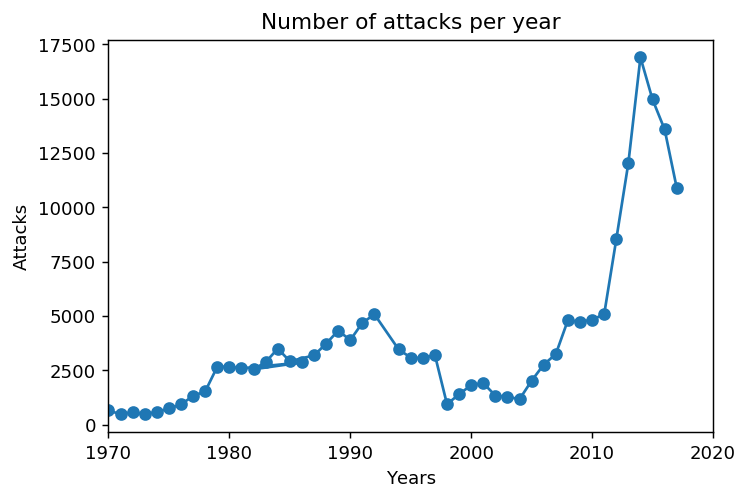

In [21]:
list_years = data['Year'].values
ctr = Counter(list_years)


plt.figure(num=None, figsize=(6, 4), dpi=130, facecolor='w', edgecolor='k')
plt.plot(list(ctr.keys()),list(ctr.values()),'-o')
plt.title("Number of attacks per year")
plt.xlim((1970,2020))
plt.ylabel("Attacks")
plt.xlabel("Years")
plt.show()

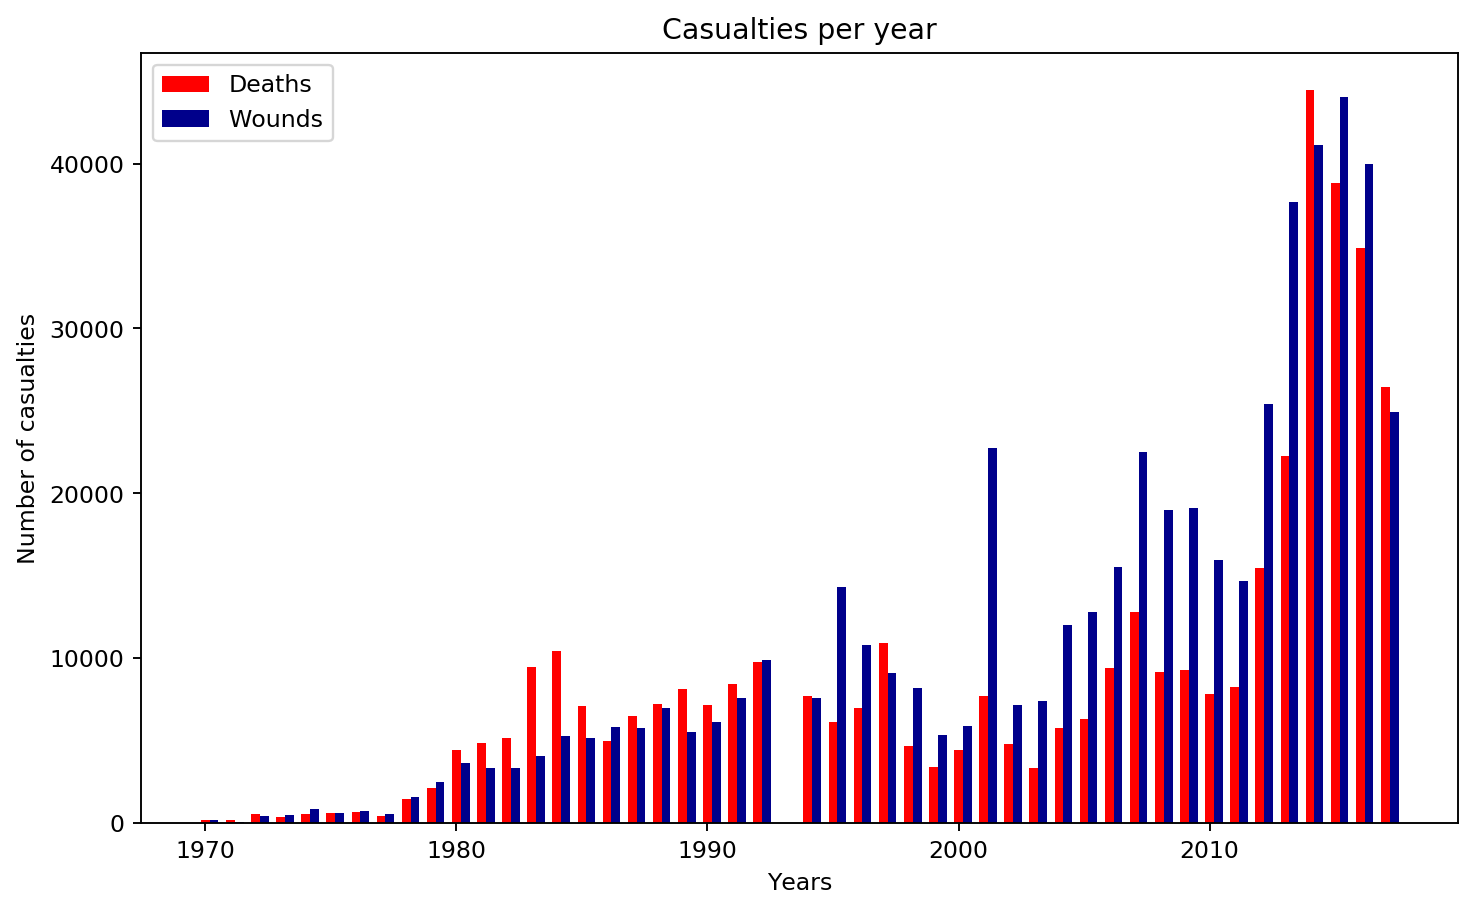

In [88]:
event_kills = [(int(x),int(y)) for [x,y] in data[['Year','Kills']].values]
year_deaths = defaultdict(int)
for (x,y) in event_kills:
    year_deaths[x] += y
    
event_wounds = [(int(x),int(y)) for [x,y] in data[['Year','Wounds']].values]
year_wounded = defaultdict(int)
for (x,y) in event_wounds:
    year_wounded[x] += y
    

plt.figure(num=None, figsize=(10, 6), dpi=170, facecolor='w', edgecolor='k')
plt.bar(year_deaths.keys(),year_deaths.values(),0.35,color='red')
plt.bar(np.array(list(year_wounded.keys()))+0.35,year_wounded.values(),0.35,color='darkblue')
plt.xlabel('Years')
plt.ylabel('Number of casualties')
plt.title('Casualties per year')
plt.legend(('Deaths','Wounds'))
plt.show()

In [47]:
fig = plt.figure(num=None, figsize=(6, 4), dpi=170, facecolor='w', edgecolor='k')

event_coord = [(x,l,t,k+w) for [x,l,t,k,w] in data[['Year','Latitude','Longitude','Kills','Wounds']].values]
year_coord = defaultdict(list)
for (x,l,t,c) in event_coord:
    if not math.isnan(l) and not math.isnan(t):
        year_coord[int(x)].append((l,t,c)) 

m = Basemap(projection='cyl', resolution=None,
    llcrnrlat=-90, urcrnrlat=90,
    llcrnrlon=-180, urcrnrlon=180,suppress_ticks=True)    

try:
    m.shadedrelief()
except:
    a=0 
    
markers = 0 

def update(year):
    global markers
    ax = plt.axes()
    ax.set_title("Attacks around the world in "+str(int(year)))
    if markers != 0:
        markers.remove() 
        
    points = [(c,m(y,x)) for x,y,c in year_coord[int(year)]]
    points.sort(reverse=True)
    points = points[0:int(len(points)/10)]
    markers = ax.scatter([x for _,(x,_) in points],[y for _,(_,y) in points],
                         s=[c/7 for c,_ in points],color='red',alpha=0.5,linewidths=0)
    
animation = ani.FuncAnimation(fig, update, sorted(list(year_coord.keys())))

animation.save('map.gif', writer='imagemagick', fps=1)
plt.close(1)

/home/matheusfebarbosa/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


<img src="map.gif" width="1280" height="470" />

/home/matheusfebarbosa/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:1442: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_xlim(*args, **kwargs)
/home/matheusfebarbosa/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:1479: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_ylim(*args, **kwargs)


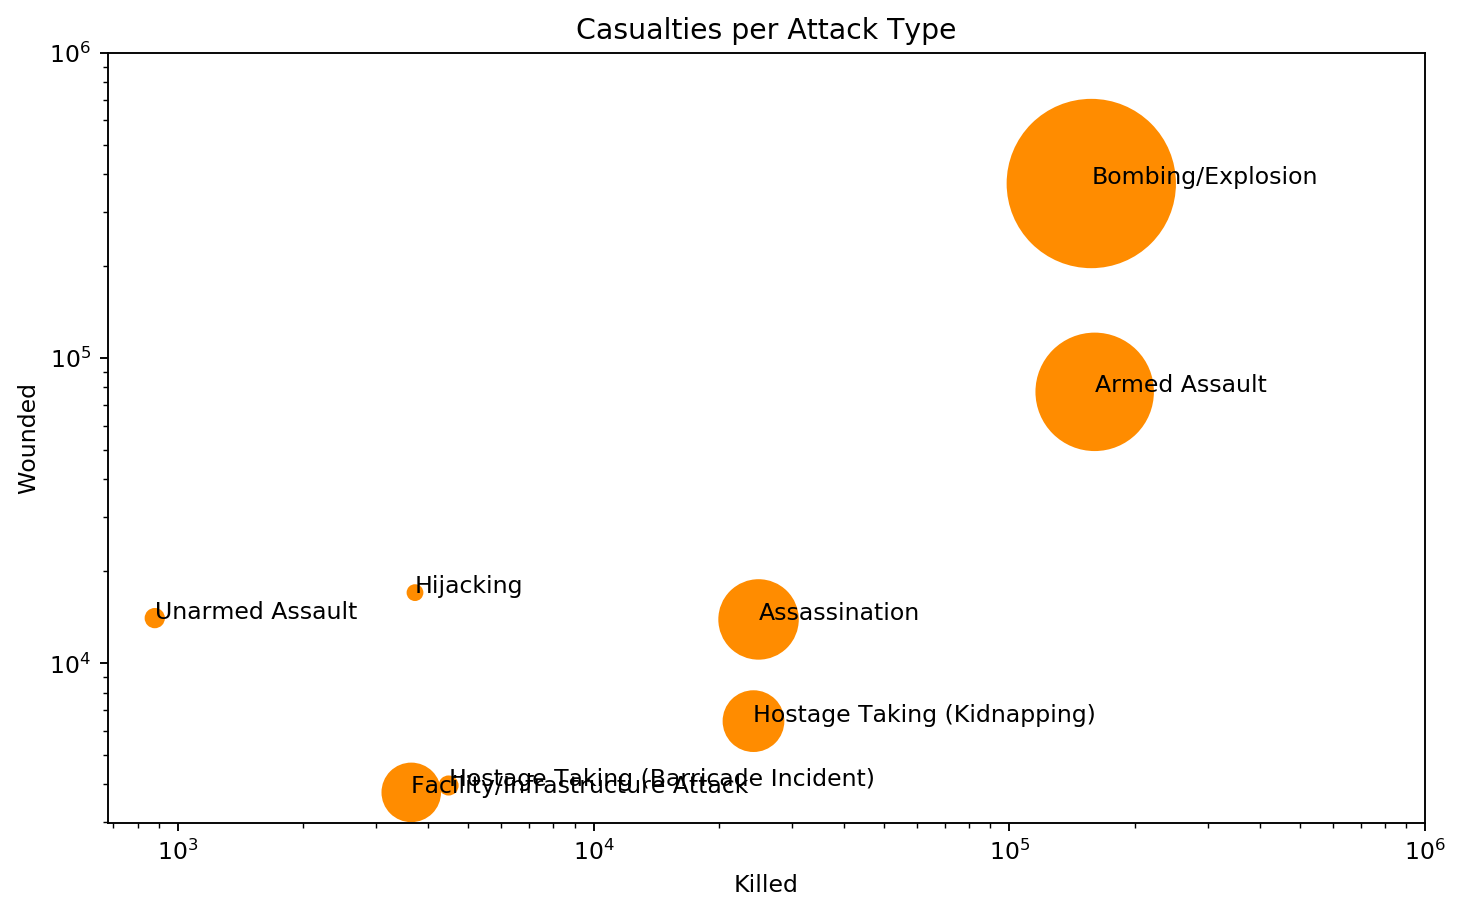

In [33]:
fig = plt.figure(num=None, figsize=(10, 6), dpi=170, facecolor='w', edgecolor='k')

att_kw = data.groupby(['AttackType'])['Kills','Wounds'].sum()
att_n = data.groupby(['AttackType']).size().reset_index(name='Number').set_index('AttackType')

att_kw.drop(['Unknown'],inplace=True)
att_n.drop(['Unknown'],inplace=True)

ax = plt.axes()
plt.scatter(att_kw['Kills'],att_kw['Wounds'],s=(att_n['Number']/max(att_n['Number'])*5000),color='darkorange')

for i,dt in att_kw.iterrows():
    ax.annotate(i,xy=(dt['Kills'],dt['Wounds']),)
    
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Killed')
plt.ylabel('Wounded')
plt.title('Casualties per Attack Type')
plt.xlim((0,10**6))
plt.ylim((0,10**6))
plt.show()

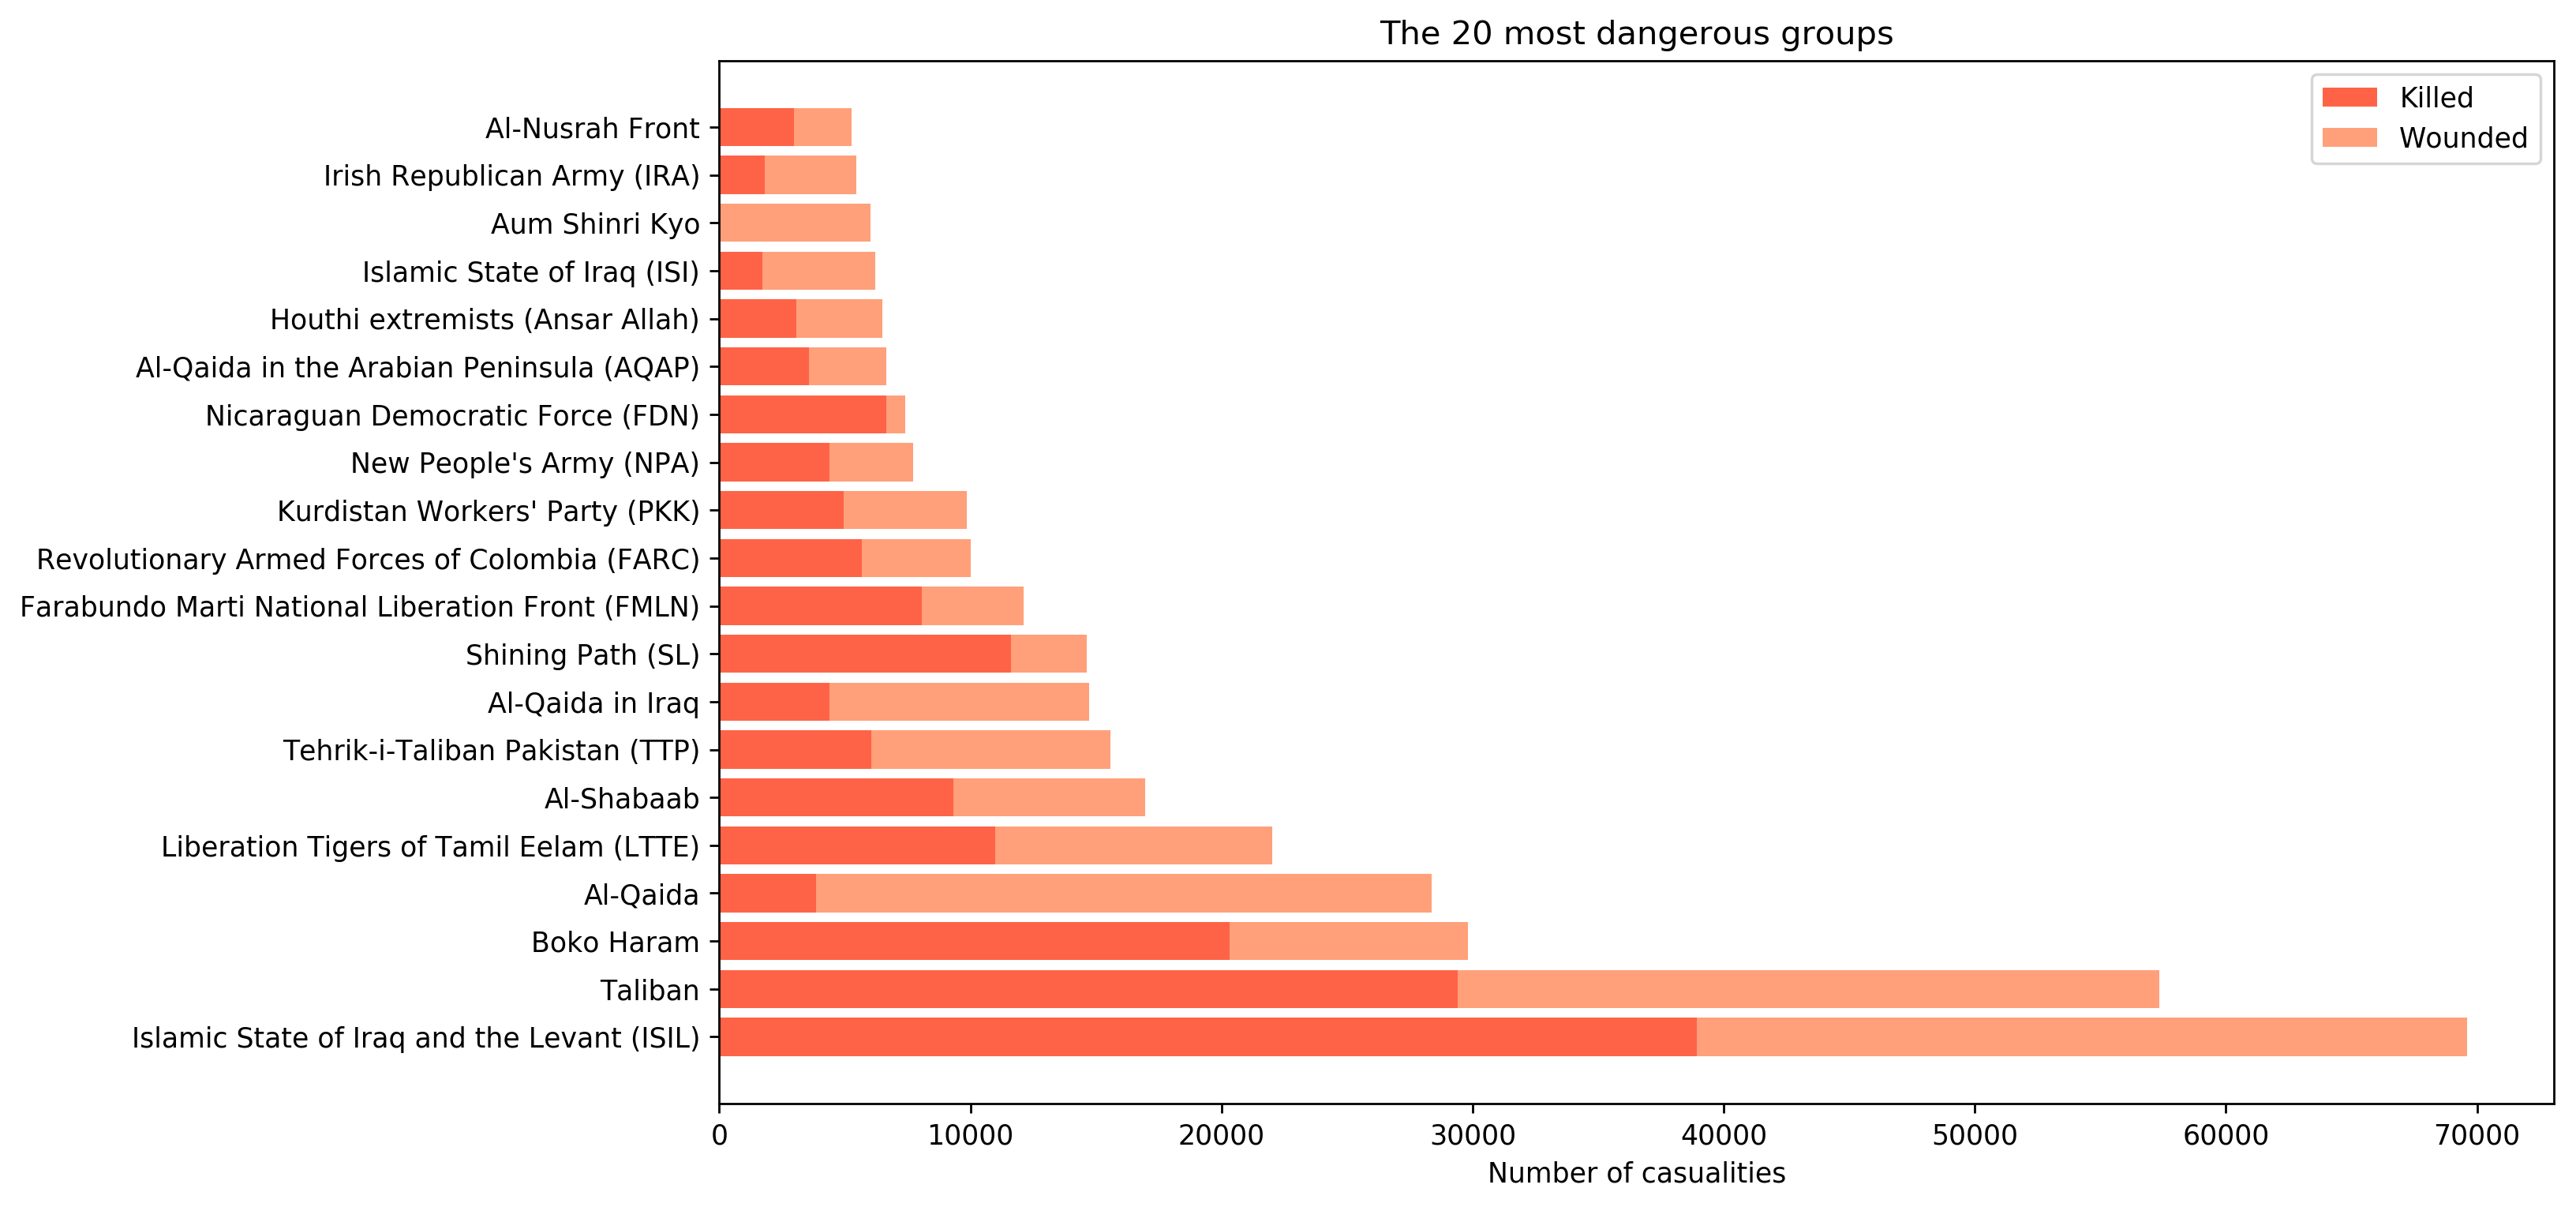

In [74]:
fig = plt.figure( figsize=(12, 7), dpi=250, facecolor='w', edgecolor='k')

group_kw = data.groupby(['Group'])['Kills','Wounds'].sum()
group_n = data.groupby(['Group']).size().reset_index(name='Attacks').set_index('Group')
group_kw = group_kw.assign(casualties=group_kw.sum(axis=1))

group_kw.drop(['Unknown'],inplace=True)
group_n.drop(['Unknown'],inplace=True)

group_n = group_n.sort_values(by=['Attacks'],ascending=False).head(20)
group_kw = group_kw.sort_values(by=['casualties'],ascending=False).head(20)

plt.barh(group_kw.index,group_kw['Kills'],color='tomato')
plt.barh(group_kw.index,group_kw['Wounds'],left=group_kw['Kills'],color='lightsalmon')
plt.xlabel("Number of casualities")
plt.legend(("Killed","Wounded"))
plt.title("The 20 most dangerous groups")

plt.show()

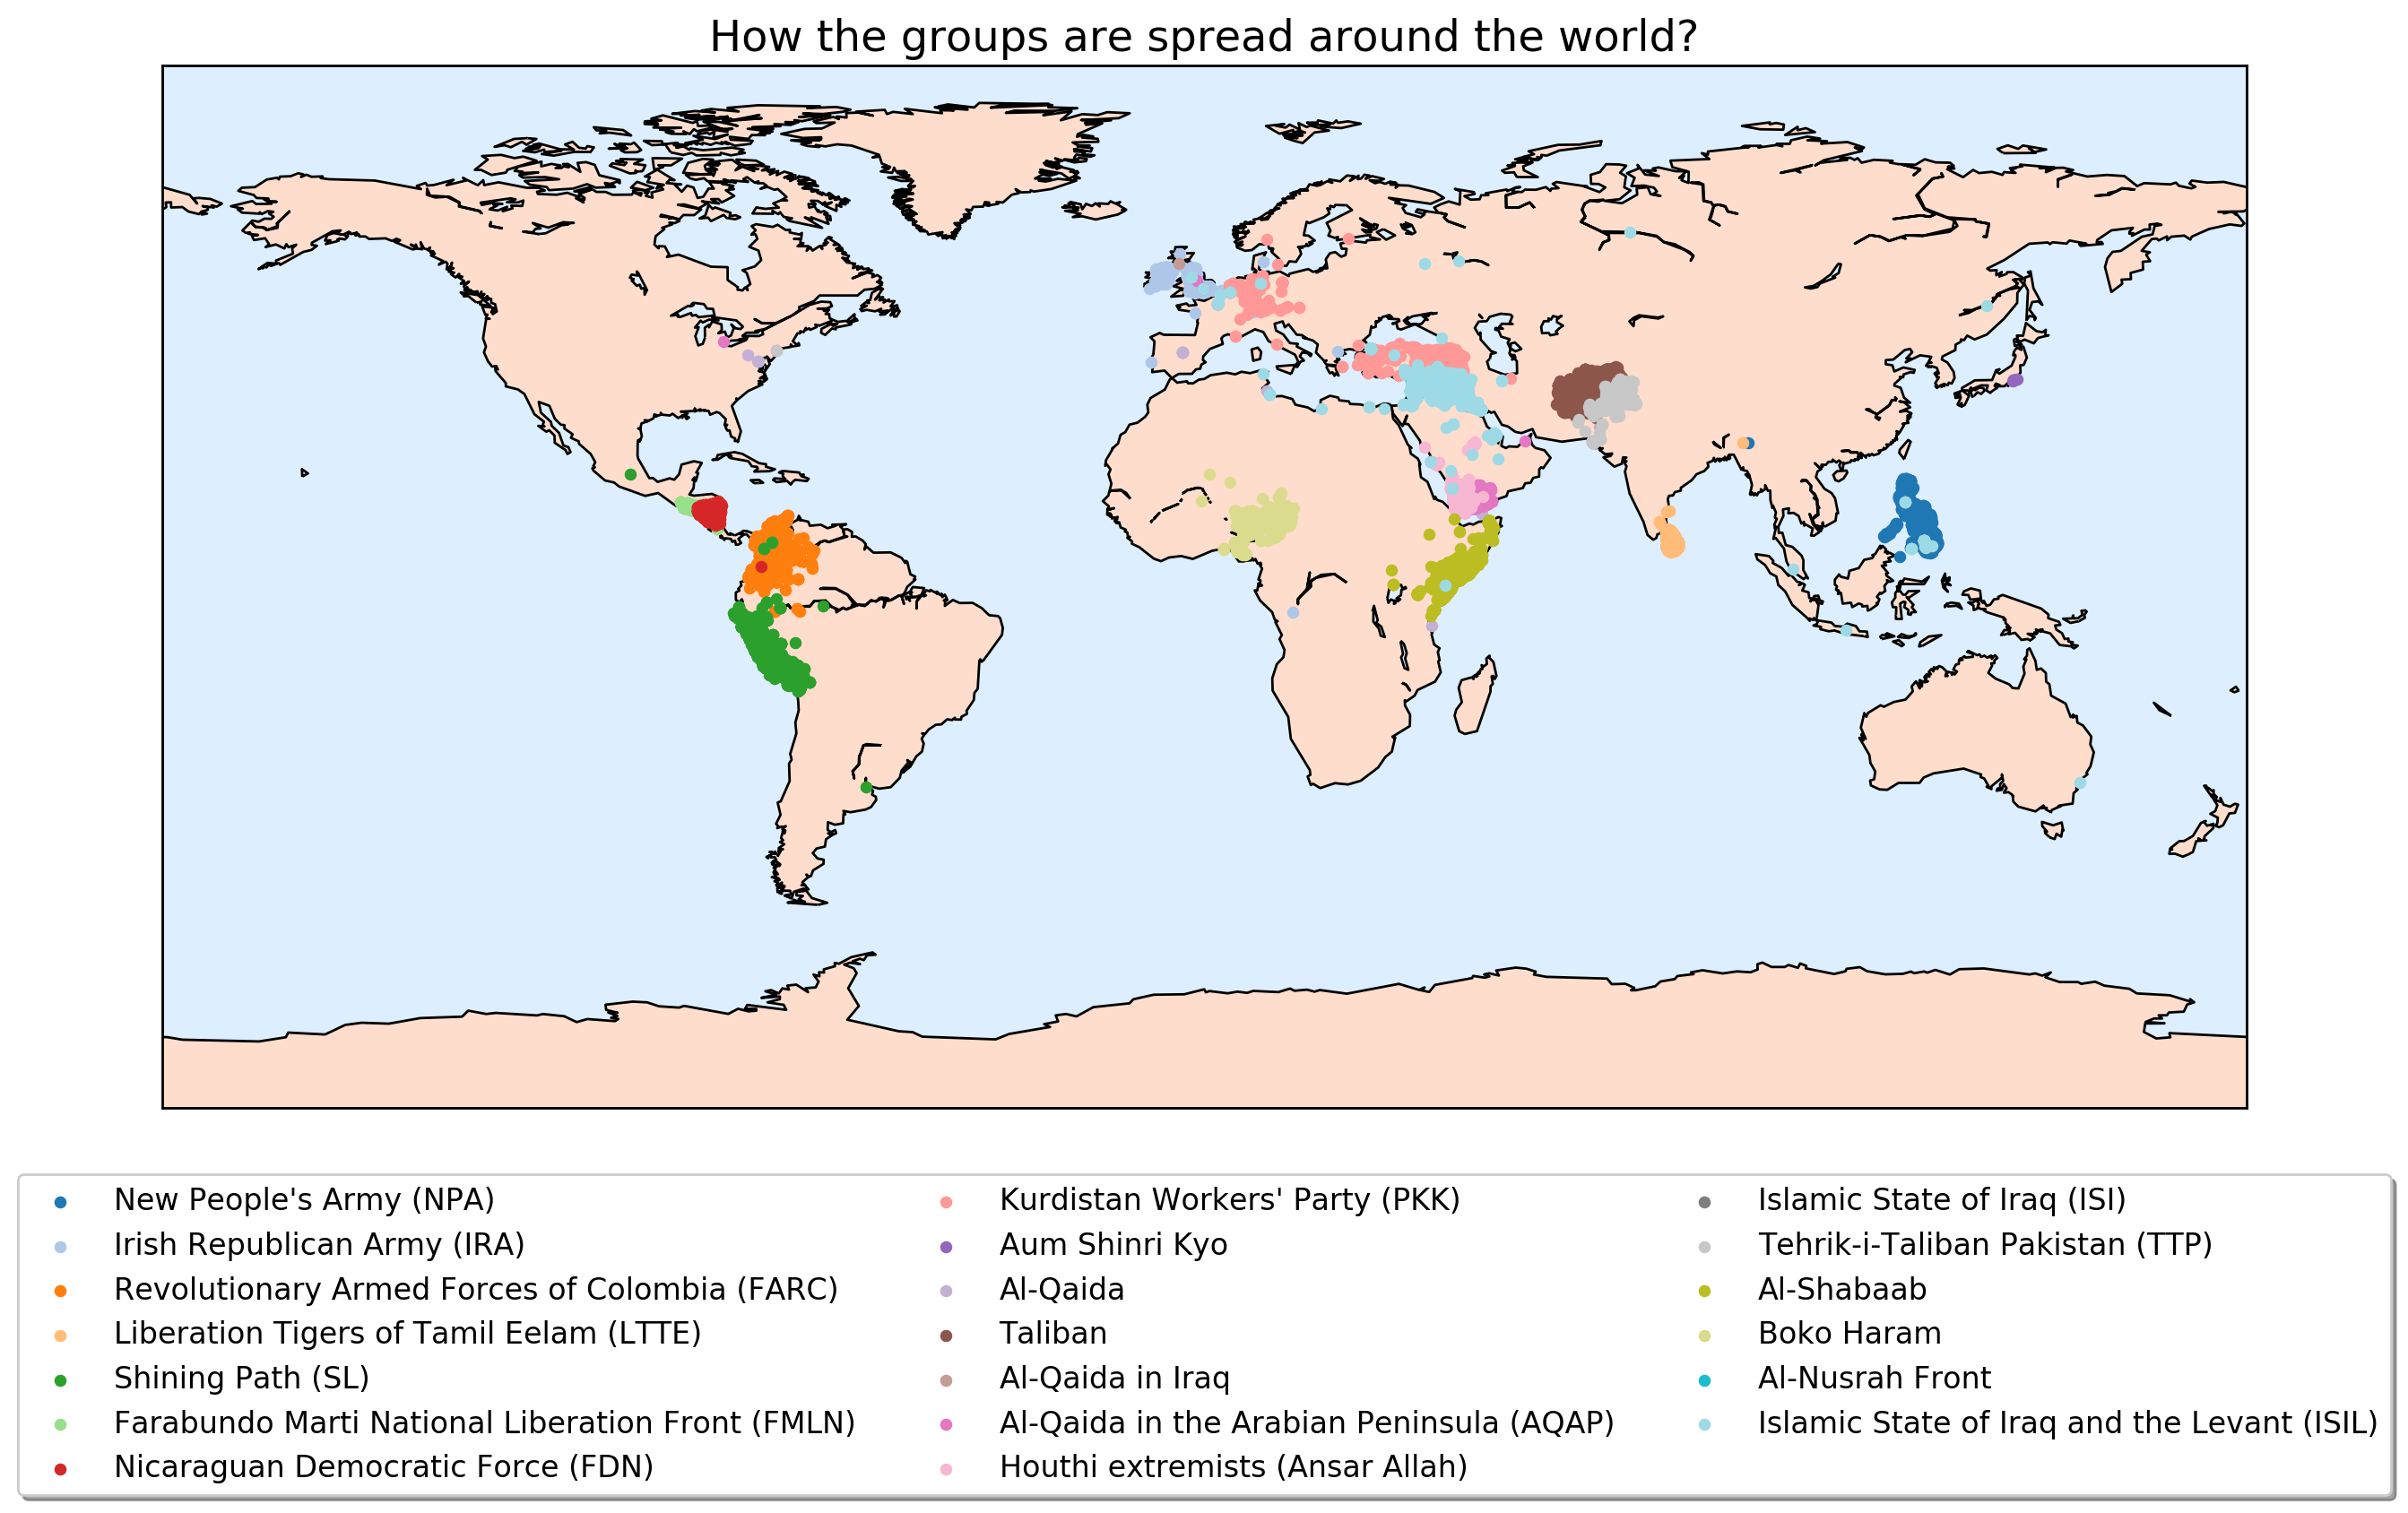

In [148]:
fig = plt.figure(figsize=(15, 10), dpi=200, facecolor='w', edgecolor='k')

event_coord = [(x,l,t) for [x,l,t] in data[['Group','Latitude','Longitude']].values]
group_coord = defaultdict(list)
for (x,l,t) in event_coord:
    if x in group_kw.index and (l != 0  or t!=0):
        group_coord[x].append((l,t)) 

m = Basemap(projection='cyl',
    llcrnrlat=-90, urcrnrlat=90,
    llcrnrlon=-180, urcrnrlon=180)    

ax = plt.axes()
ax.set_title("How the groups are spread around the world?",
          fontsize='xx-large')

m.fillcontinents(color="#FFDDCC", lake_color='#DDEEFF',ax=ax)
m.drawmapboundary(fill_color="#DDEEFF")
m.drawcoastlines()

colors = iter(cm.tab20(np.linspace(0, 1, len(group_coord.keys()))))
for key in group_coord.keys():
    points = [m(y,x) for x,y in group_coord[key]]
    ax.scatter([x for x,_ in points],[y for _,y in points],s=15,label=key,zorder=10,color=next(colors))

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=3,
          fontsize='large')

plt.show()